In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [60]:
labels = pd.read_csv("datasets/bee_data.csv", index_col=0)

def get_image(image_id, root="datasets/bee_imgs/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = f"{image_id}"
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)


In [61]:
labels.head()

,date,time,location,zip code,subspecies,health,pollen_carrying,caste
file,,,,,,,,
041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


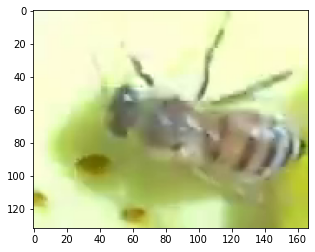

In [63]:
plt.imshow(get_image("041_073.png"))
plt.show()


In [64]:
labels.subspecies.unique()

array(['-1', 'Italian honey bee', 'VSH Italian honey bee',
       'Carniolan honey bee', 'Russian honey bee',
       '1 Mixed local stock 2', 'Western honey bee'], dtype=object)

In [65]:
labels[labels.subspecies=="Italian honey bee"]
labels.iloc[:, 0]

file
041_066.png    8/28/18
041_072.png    8/28/18
041_073.png    8/28/18
041_067.png    8/28/18
041_059.png    8/28/18
                ...   
027_011.png    8/20/18
027_007.png    8/20/18
027_013.png    8/20/18
027_012.png    8/20/18
027_014.png    8/20/18
Name: date, Length: 5172, dtype: object

In [66]:
labels = labels.reset_index()

In [67]:
labels.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [68]:
labels.file

0       041_066.png
1       041_072.png
2       041_073.png
3       041_067.png
4       041_059.png
           ...     
5167    027_011.png
5168    027_007.png
5169    027_013.png
5170    027_012.png
5171    027_014.png
Name: file, Length: 5172, dtype: object

In [80]:
def show_image(index):
    """
    Displays an image from the dataset with subspecies.
    """
    file_name = labels[labels.index==index].file.values[0]
    subspecies = labels[labels.index==index].subspecies.values[0]
    img = get_image(file_name)
    plt.imshow(img)
    plt.show()
    return subspecies
    

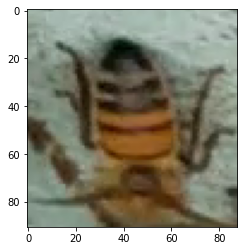

'Italian honey bee'

In [82]:
show_image(5000)